In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080 Ti'

In [3]:
from transformers import set_seed
set_seed(2)

In [4]:
from datasets import load_dataset

datasets = load_dataset("indic_glue","csqa.bn",split="test")

Found cached dataset indic_glue (/home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95)


In [6]:
datasets = datasets.train_test_split(
    train_size=0.9, seed=42
)
datasets

Loading cached split indices for dataset at /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-a58685f4b09aba66.arrow and /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-6ec454a162a4dce4.arrow


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'category', 'title', 'options', 'out_of_context_options'],
        num_rows: 34960
    })
    test: Dataset({
        features: ['question', 'answer', 'category', 'title', 'options', 'out_of_context_options'],
        num_rows: 3885
    })
})

In [7]:
datasets["train"][0]

{'question': 'প্রতিবছর হজ্জের সময় মদিনায় অবস্থানরত কোনো হজ্জ পালনকারীর  মৃত্যু হলে  জান্নাতুল বাকীতে দাফন করা হয়। এছাড়াও মদীনার বাসিন্দারাও মারা গেলে এখানে দাফনের সুযোগ পায়।  তবে <MASK>-এর সাহাবাদের ইতিহা সংরক্ষণের অংশ হিসেবে এ কবরস্থানের শুরুর অংশে যাদের সমাহিত করা হয়েছে তাদের স্থানে এখন আর নতুন করে কাউকে কবরস্থ  করা হয় না। সৌদি সরকারের তত্ত্ববধানে জান্নাতুল বাকী জিয়ারতের জন্য ফজর ও আসরের নামাজের পর খুলে দেয়া হয়। এসময় মুসলিম পুরুষরা জিয়ারতের জন্য ভেতরে যেতে পারে। ইসলামি শরিয়তে নারীদের কবর জেয়ারত করা বৈধ নয় মর্মে তাদের যেতে দেয়া হয় না।',
 'answer': 'মুহাম্মাদ',
 'category': 'PER',
 'title': 'জান্নাতুল বাকি',
 'options': ['মুহাম্মদ', 'মুহাম্মাদ', 'খাদিজাসহ', 'ফাতিমার'],
 'out_of_context_options': []}

In [12]:
from transformers import PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer

# tokenizer = PreTrainedTokenizerFast.from_pretrained("../Bengali Pretraining/models/unigram/bert-base-pretrained-bengali")
tokenizer = PreTrainedTokenizerFast.from_pretrained("../Bengali Pretraining/models/unigram/unigram-long-text")

In [13]:
choice_names = ['options']

In [14]:
def preprocess_function(examples):
    premise = [[context.replace("<MASK>","[MASK]")] * 4 for context in examples["question"]]
    cause = [examples['options'][i] for i,_ in enumerate(premise)]

    premise = sum(premise, [])
    cause = sum(cause, [])
    
    # print(premise)
    # print(cause)
    

    tokenized_examples = tokenizer(premise, cause, truncation=True, max_length=128)
#     print(len(tokenized_examples))
    return {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}
    #return tokenized_examples

In [15]:
temp = preprocess_function(datasets["train"][:1])
# temp

In [16]:
datasets["train"][:1]

{'question': ['প্রতিবছর হজ্জের সময় মদিনায় অবস্থানরত কোনো হজ্জ পালনকারীর  মৃত্যু হলে  জান্নাতুল বাকীতে দাফন করা হয়। এছাড়াও মদীনার বাসিন্দারাও মারা গেলে এখানে দাফনের সুযোগ পায়।  তবে <MASK>-এর সাহাবাদের ইতিহা সংরক্ষণের অংশ হিসেবে এ কবরস্থানের শুরুর অংশে যাদের সমাহিত করা হয়েছে তাদের স্থানে এখন আর নতুন করে কাউকে কবরস্থ  করা হয় না। সৌদি সরকারের তত্ত্ববধানে জান্নাতুল বাকী জিয়ারতের জন্য ফজর ও আসরের নামাজের পর খুলে দেয়া হয়। এসময় মুসলিম পুরুষরা জিয়ারতের জন্য ভেতরে যেতে পারে। ইসলামি শরিয়তে নারীদের কবর জেয়ারত করা বৈধ নয় মর্মে তাদের যেতে দেয়া হয় না।'],
 'answer': ['মুহাম্মাদ'],
 'category': ['PER'],
 'title': ['জান্নাতুল বাকি'],
 'options': [['মুহাম্মদ', 'মুহাম্মাদ', 'খাদিজাসহ', 'ফাতিমার']],
 'out_of_context_options': [[]]}

In [17]:
for chunk in temp['input_ids'][0]:
    print(tokenizer.decode(chunk))

[CLS] প্রতিবছর হজ্জের সময় মদিনায় অবস্থানরত কোনো হজ্জ পালনকারীর মৃত্যু হলে জান্নাতুল বাকীতে দাফন করা হয়। এছাড়াও মদীনার বাসিন্দারাও মারা গেলে এখানে দাফনের সুযোগ পায়। তবে [MASK] [UNK]এর সাহাবাদের ইতিহা সংরক্ষণের অংশ হিসেবে এ কবরস্থানের শুরুর অংশে যাদের সমাহিত করা হয়েছে তাদের স্থানে এখন আর নতুন করে কাউকে কবরস্থ করা হয় না। সৌদি সরকারের তত্ত্ববধানে জান্নাতুল বাকী জিয়ারতের জন্য ফজর ও আসরের নামাজের পর খুলে দেয়া হয়। এসময় মুসলিম পুরুষরা জিয়ারতের জন্য ভেতরে যেতে পারে। ইসলামি শরিয়তে নারীদের কবর জেয়ারত করা বৈধ নয় মর্মে তাদের[SEP] মুহাম্মদ[SEP]
[CLS] প্রতিবছর হজ্জের সময় মদিনায় অবস্থানরত কোনো হজ্জ পালনকারীর মৃত্যু হলে জান্নাতুল বাকীতে দাফন করা হয়। এছাড়াও মদীনার বাসিন্দারাও মারা গেলে এখানে দাফনের সুযোগ পায়। তবে [MASK] [UNK]এর সাহাবাদের ইতিহা সংরক্ষণের অংশ হিসেবে এ কবরস্থানের শুরুর অংশে যাদের সমাহিত করা হয়েছে তাদের স্থানে এখন আর নতুন করে কাউকে কবরস্থ করা হয় না। সৌদি সরকারের তত্ত্ববধানে জান্নাতুল বাকী জিয়ারতের জন্য ফজর ও আসরের নামাজের পর খুলে দেয়া হয়। এসময় মুসলিম পুরুষরা জিয়ার

In [18]:
tokenized_datasets = datasets.map(preprocess_function, batched=True)

Loading cached processed dataset at /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-0377072320f2a072.arrow
Loading cached processed dataset at /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-3f58b7ca2f80cbae.arrow


In [19]:
def assign_label(example):
    options = example['options']
    example['label'] = options.index(example['answer'])
    return example

In [20]:
tokenized_datasets = tokenized_datasets.map(assign_label)

Loading cached processed dataset at /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-f107e19ee017e972.arrow
Loading cached processed dataset at /home/ashahri1/.cache/huggingface/datasets/indic_glue/csqa.bn/1.0.0/082910ba488a202e0b57bfff0222f736130a17028e9ff242e4d537bd2fe6cd95/cache-c47933b069fb3b17.arrow


In [21]:
tokenized_datasets["train"][2]["label"]

1

In [22]:
datasets["train"][2]

{'question': 'বাংলাদেশ দক্ষিণ এশিয়ার একটি সার্বভৌম রাষ্ট্র যার আনুষ্ঠানিক নাম গণপ্রজাতন্ত্রী বাংলাদেশ।   বাংলাদেশের পশ্চিম, উত্তর ও পূর্ব সীমান্তে আছে <MASK>, দক্ষিণ-পূর্ব সীমান্তে আছে মায়ানমার, আর দক্ষিণ উপকূলের দিকে আছে বঙ্গোপসাগর। বাংলাদেশ ভৌগলিকভাবে একটি উর্বর বদ্বীপের উপরে অবস্থিত আছে। উল্লেখযোগ্য, বাংলাদেশ ও পার্শ্ববর্তী ভারতীয় রাজ্য পশ্চিমবঙ্গ ও ত্রিপুরা একত্রে একটি অবিচ্ছিন্ন বাঙালি জাতিগত ও বাংলা-ভাষীগত অঞ্চল গঠন করে যার নাম "বঙ্গ" বা "বাংলা"। বঙ্গের পূর্বাংশ বা পূর্ব বাংলা ইতিহাসের ধারাবাহিকতায় বাংলাদেশ নামীয় পৃথক একটি আধুনিক জাতিরাষ্ট্র হিসাবে প্রতিষ্ঠিত হয়।',
 'answer': 'ভারত',
 'category': 'ORG',
 'title': 'বাংলাদেশের রূপরেখা',
 'options': ['ইন্টারপোল', 'ভারত', 'বাংলাদেশ', 'মায়ানমার'],
 'out_of_context_options': []}

In [23]:
# from transformers import set_seed
# set_seed(30)

In [24]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoModel

# model = AutoModelForMultipleChoice.from_pretrained("../Bengali Pretraining/models/unigram/bert-base-pretrained-bengali")
model = AutoModelForMultipleChoice.from_pretrained("../Bengali Pretraining/models/unigram/unigram-long-text")

Some weights of the model checkpoint at ../Bengali Pretraining/models/unigram/unigram-long-text were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at ../Bengali Pretrainin

In [25]:
model = AutoModelForMultipleChoice.from_pretrained("qa_model")

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'category', 'title', 'options', 'out_of_context_options', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 34960
    })
    test: Dataset({
        features: ['question', 'answer', 'category', 'title', 'options', 'out_of_context_options', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 3885
    })
})

In [27]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch


@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [28]:
data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer)

In [29]:
import evaluate

accuracy = evaluate.load("accuracy")

In [30]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [31]:
#  disable weights and biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

In [32]:
training_args = TrainingArguments(
    output_dir="qa_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    #learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    #num_train_epochs=3,
    num_train_epochs=4,
    #warmup_ratio=0.1,
    weight_decay=0.01,
    #weight_decay=0.04,
    fp16=True,
    metric_for_best_model = 'accuracy',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using amp half precision backend


In [33]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, category, options, out_of_context_options, title, answer.
***** Running Evaluation *****
  Num examples = 3885
  Batch size = 32


{'eval_loss': 0.9753087759017944,
 'eval_accuracy': 0.5616473616473616,
 'eval_runtime': 16.2899,
 'eval_samples_per_second': 238.491,
 'eval_steps_per_second': 7.489}

In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: out_of_context_options, answer, category, options, title, question.
***** Running training *****
  Num examples = 34960
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4372


Epoch,Training Loss,Validation Loss,Accuracy
1,1.329100,1.307188,0.349807
2,1.136300,1.024150,0.511969
3,0.931100,0.964603,0.554183
4,0.803600,0.975309,0.561647


The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: out_of_context_options, answer, category, options, title, question.
***** Running Evaluation *****
  Num examples = 3885
  Batch size = 32
Saving model checkpoint to qa_model/checkpoint-1093
Configuration saved in qa_model/checkpoint-1093/config.json
Model weights saved in qa_model/checkpoint-1093/pytorch_model.bin
tokenizer config file saved in qa_model/checkpoint-1093/tokenizer_config.json
Special tokens file saved in qa_model/checkpoint-1093/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: out_of_context_options, answer, category, options, title, question.
***** Running Evaluation *****
  Num examples = 3885
  Batch size = 32
Saving model checkpoint to qa_model/checkpoint-2186
Configuration saved in qa_model/checkpoint-2186/config.jso

TrainOutput(global_step=4372, training_loss=1.0632272285817417, metrics={'train_runtime': 1886.7186, 'train_samples_per_second': 74.118, 'train_steps_per_second': 2.317, 'total_flos': 3.679311962800128e+16, 'train_loss': 1.0632272285817417, 'epoch': 4.0})

In [33]:
trainer.save_model()

Saving model checkpoint to qa_model
Configuration saved in qa_model/config.json
Model weights saved in qa_model/pytorch_model.bin
tokenizer config file saved in qa_model/tokenizer_config.json
Special tokens file saved in qa_model/special_tokens_map.json


In [34]:
y_preds, y_true, _ = trainer.predict(tokenized_datasets["test"])

The following columns in the test set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, category, options, out_of_context_options, title, answer.
***** Running Prediction *****
  Num examples = 3885
  Batch size = 32


In [35]:
y_preds = np.argmax(y_preds, axis=-1)

In [36]:
from sklearn.metrics import classification_report
target_names = ['choice1', 'choice2','choice3','choice4']

Text(0.5, 1.0, 'Confusion matrix for Clozed QA')

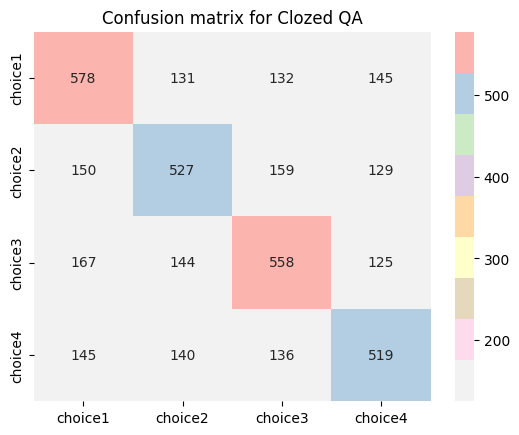

In [37]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

#plot heatmap of confusion matrix
mat = confusion_matrix(y_true, y_preds)
heatmap(mat, cmap="Pastel1_r", fmt="d", xticklabels=target_names, yticklabels=target_names, annot=True)

#add overall title to plot
plt.title('Confusion matrix for Clozed QA', fontsize = 12) # title with fontsize 20

In [194]:
misclassified = [i for i in range(len(y_preds)) if ((y_preds[i] != y_true[i]) and (y_true[i]==1) and (y_preds[i]==0))]

In [195]:
misclassified_dataset = tokenized_datasets['test'].select(misclassified)

In [196]:
idx=0
misclassified[idx]

1

In [201]:
misclassified_dataset[33]
# misclassified_dataset[30:60]['title']

{'question': '২০১৭ সালের ফেব্রুয়ারি মাসে মায়া আপা <MASK>র সাথে একটি প্রিমিয়াম সার্ভিস চালু করে যাকে মায়া আপা প্লাস নামে সম্মোধন করা হয় এবং এটা শুধু মাত্র রবির গ্রাহকদের জন্য উপলব্ধ ছিল। মায়া আপা প্লাস মোবাইল অ্যাপের সাবস্ক্রিপশন প্যাকেজ ও এসএমএসের মাধ্যমে  উপলব্ধ করা হয়েছিল। এই প্রিমিয়াম পরিষেবা ১০ মিনিটের মধ্যে গ্রাহকদের প্রশ্নের উত্তর দেয় এবং মোবাইল অ্যাপ্লিকেশনের একটি অতিরিক্ত বৈশিষ্ট্য প্রদান করে।',
 'answer': 'রবি',
 'category': 'ORG',
 'title': 'মায়া আপা',
 'options': ['ব্র্যাক', 'রবি', 'গুগল', 'Katmando'],
 'out_of_context_options': ['Katmando'],
 'input_ids': [[2,
   5,
   0,
   264,
   704,
   455,
   3841,
   6714,
   5,
   4,
   5,
   10,
   4704,
   36,
   17255,
   2780,
   722,
   15,
   5623,
   3841,
   6714,
   7116,
   400,
   19767,
   2953,
   2205,
   43,
   19,
   16,
   123,
   149,
   196,
   305,
   15400,
   4513,
   25,
   2696,
   24201,
   38,
   6,
   3841,
   6714,
   7116,
   1346,
   13984,
   5374,
   18739,
   139,
   600,
   326,
   43,
   